### **Still to do**


*   Reduce Matrices inside clasification and accuracies.
---------------------------
In the other file
*   Analyse the dot product if it optimizes the accuracy
*   Make a fidelity measure
*   (Idea) Check the distribution of the eigenvectors along the basis.
-------------------------------
Almost done
*   Implement Save and Load. Implement filename's time details inside the function?
*   Include two or three data sets with a simple way to be implemented (Already Spiral, moons and circles)



In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_moons, make_swiss_roll
from sklearn import preprocessing
from functools import reduce #To use multiple np.kron

import math

import time

#from qiskit.quantum_info import state_fidelity


# File Management

In [45]:

import os
print(os.getcwd())  # Confirm the current working directory
print(os.listdir())  # Check for the notebook file

/home/hgutierrez/Documents/Thesis/Thesis-Und
['Average_Parallel_Copy.ipynb', 'Saved_arrays', 'local_library.py', 'Figures.ipynb', '__pycache__', '.git', 'Av_Parallel.py~', 'Average.ipynb', 'Av_Parallel.py', 'Average_Parallel.ipynb', '.Av_Parallel.py.un~']


In [46]:
### Asuming we are already in the right directory

%ls
directory_arrays = './Saved_arrays/'

Av_Parallel.py   Average_Parallel.ipynb       Saved_arrays/
Av_Parallel.py~  Average_Parallel_Copy.ipynb  __pycache__/
Average.ipynb    Figures.ipynb                local_library.py


In [47]:
#import import_ipynb
from local_library import *

# Some functions

In [48]:
def clasification_and_accuracies(quantum_feature_map, num_points, N_qfm, param_qfm, N_grid, random_seed, dataset_generator, rescaling=2/3, plot = False):

    accuracy = np.zeros(3) #pure and mixed and diagonal
    dataset = (dataset_generator.__name__)[9:]

    train_arr, train_lb, test_arr, test_lb = dataset_generator(num_points, random_seed)

    diminish_size(train_arr, scale = rescaling)
    diminish_size(test_arr, scale = rescaling)

    if not plot: N_grid = 1 # It takes small time in the grid

    grid_QFM, grid_xy = make_grid(quantum_feature_map, N_qfm, param_qfm, N_grid)

    train_QFM_x0, train_QFM_x1, test_QFM_x = make_QFM(quantum_feature_map, N_qfm, param_qfm, train_arr, train_lb, test_arr)

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[0] = measurement_pure( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM)

    if plot: plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[0], dataset, quantum_feature_map, 'pure')

    # Generate density matrices outside 'measurement_mixed'
    #mdensity_x0 = mixed_density(train_QFM_x0)
    #mdensity_x1 = mixed_density(train_QFM_x1)

    # Reduce the matrix dimension
    #mdensity_x0 = reduce_matrix(mdensity_x0, threshold=0.01)
    #mdensity_x1 = reduce_matrix(mdensity_x1, threshold=0.01)
    ### The reduction is not useful here because it keeps the original matrix dimension

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[1], mdensity_x0, mdensity_x1 = measurement_mixed( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM)#, density_x0 = mdensity_x0, density_x1 = mdensity_x1)

    if plot: plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[1], dataset, quantum_feature_map, 'mixed')

    ## Trace product
    int_prod = np.abs(np.trace(np.matmul(mdensity_x0,mdensity_x1)))

    # Cut the lowest eigenvectors
    #mdensity_x0 = reduce_matrix(mdensity_x0, threshold=0.001)
    #mdensity_x1 = reduce_matrix(mdensity_x1, threshold=0.001)

    mdensity_x0 = mdensity_x0 / np.trace(mdensity_x0)
    mdensity_x1 = mdensity_x1 / np.trace(mdensity_x1)

    ## Fidelity
    #fidelity_value = state_fidelity(mdensity_x0,mdensity_x1)

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[2] = measurement_diagonal( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM, density_x0 = mdensity_x0, density_x1 = mdensity_x1)

    if plot: plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[2], dataset, quantum_feature_map, 'classical')

    return accuracy, int_prod, 0#fidelity_value

#clasification_and_accuracies(coherent, num_points, N_qfm, param_qfm, N_grid, random_seed, generate_spirals, plot = True)

In [49]:
from scipy.ndimage import gaussian_filter

def global_minimum(data, sigma):
    """
    Finds the global minimum after softening the data with a Gaussian filter.

    Parameters:
    - data (array-like): The input data.
    - sigma (float): The standard deviation for Gaussian smoothing.

    Returns:
    - float: The global minimum of the smoothed data.
    """
    smoothed_data = gaussian_filter(data, sigma=sigma)
    return np.min(smoothed_data), np.argmin(smoothed_data)

def global_maximum(data, sigma):
    """
    Finds the global maximum after softening the data with a Gaussian filter.

    Parameters:
    - data (array-like): The input data.
    - sigma (float): The standard deviation for Gaussian smoothing.

    Returns:
    - float: The global maximum of the smoothed data.
    """
    smoothed_data = gaussian_filter(data, sigma=sigma)
    return np.max(smoothed_data), np.argmax(smoothed_data)

In [50]:
def save_arrays_to_file(arrays, variable_names, filename):
    """
    Saves a list of arrays into a dictionary and exports them to a .npz file.

    Parameters:
    - arrays (list of np.ndarray): The list of arrays to save.
    - variable_names (list of str): The corresponding names for the arrays.
    - filename (str): The file name to save the arrays.
    """
    if len(arrays) != len(variable_names):
        raise ValueError("Number of arrays and variable names must match.")

    array_dict = {name: array for name, array in zip(variable_names, arrays)}
    np.savez(filename, **array_dict)
    print(f"Arrays saved to {filename}")

def load_arrays_from_file(filename):
    """
    Loads arrays from a .npz file and returns a dictionary of them.

    Parameters:
    - filename (str): The file name to load the arrays from.

    Returns:
    - dict: A dictionary where keys are variable names and values are arrays.
    """
    loaded_data = np.load(filename)
    array_dict = {key: loaded_data[key] for key in loaded_data.files}
    print(f"Arrays loaded from {filename}")
    return array_dict

In [51]:
from scipy.linalg import sqrtm

def fidelity(p,q):
    return np.trace(sqrtm(np.matmul(np.matmul(sqrtm(p),q),sqrtm(p))))**2

In [52]:
"""
def fidelity_eigen(p,q, cutting_fraction = 0.01):
    eigenvalues_p, eigenvectors_p = np.linalg.eigh(p)
    eigenvalues_q, eigenvectors_q = np.linalg.eigh(q)
    # Sort eigenvalues and eigenvectors in descending order
    '''
    sorted_indices_p = np.argsort(eigenvalues_p)[::-1]
    sorted_indices_q = np.argsort(eigenvalues_q)[::-1]
    eigenvalues_p = eigenvalues_p[sorted_indices_p]
    eigenvalues_q = eigenvalues_q[sorted_indices_q]
    eigenvectors_p = eigenvectors_p[:, sorted_indices_p]
    eigenvectors_q = eigenvectors_q[:, sorted_indices_q]'''

    eigenvalues_p = eigenvalues_p[::-1]
    eigenvalues_q = eigenvalues_q[::-1]
    eigenvectors_p = eigenvectors_p[:, ::-1]
    eigenvectors_q = eigenvectors_q[:, ::-1]

    first_index_p = np.argmax(eigenvalues_p > eigenvalues_p[0]*cutting_fraction)
    first_index_q = np.argmax(eigenvalues_q > eigenvalues_q[0]*cutting_fraction)

    # Keep just the larger eigenvalues and their eigenvectors
    eigenvalues_p = eigenvalues_p[0:first_index_p]
    eigenvectors_p = eigenvectors_p[:, 0:first_index_p]
    eigenvalues_q = eigenvalues_q[0:first_index_q]
    eigenvectors_q = eigenvectors_q[:, 0:first_index_q]

    ### At this moment the programer notices that there are reasons why are optimized and predefined functions
"""

"\ndef fidelity_eigen(p,q, cutting_fraction = 0.01):\n    eigenvalues_p, eigenvectors_p = np.linalg.eigh(p)\n    eigenvalues_q, eigenvectors_q = np.linalg.eigh(q)\n    # Sort eigenvalues and eigenvectors in descending order\n    '''\n    sorted_indices_p = np.argsort(eigenvalues_p)[::-1]\n    sorted_indices_q = np.argsort(eigenvalues_q)[::-1]\n    eigenvalues_p = eigenvalues_p[sorted_indices_p]\n    eigenvalues_q = eigenvalues_q[sorted_indices_q]\n    eigenvectors_p = eigenvectors_p[:, sorted_indices_p]\n    eigenvectors_q = eigenvectors_q[:, sorted_indices_q]'''\n\n    eigenvalues_p = eigenvalues_p[::-1]\n    eigenvalues_q = eigenvalues_q[::-1]\n    eigenvectors_p = eigenvectors_p[:, ::-1]\n    eigenvectors_q = eigenvectors_q[:, ::-1]\n\n    first_index_p = np.argmax(eigenvalues_p > eigenvalues_p[0]*cutting_fraction)\n    first_index_q = np.argmax(eigenvalues_q > eigenvalues_q[0]*cutting_fraction)\n\n    # Keep just the larger eigenvalues and their eigenvectors\n    eigenvalues_p = ei

In [53]:
np.argsort([2,3,1,5])

array([2, 0, 1, 3])

# Main for pure, mixed, diag and internal product

In [106]:
from joblib import Parallel, delayed

start_time = time.time()

# Given initial definitions
quantum_feature_map = coherent
num_points = 100
dataset_generator = generate_spirals
N_grid = 1

N_qfm_arr = [20] #np.arange(30, 36, 1, dtype='int')
param_qfm_arr = np.arange(0.5, 61, 0.5)#0.5)
random_max = 15

# Preallocate arrays
acc_all = np.zeros((len(N_qfm_arr), len(param_qfm_arr), random_max,3))
internal_all = np.zeros((len(N_qfm_arr), len(param_qfm_arr), random_max))
fidelity_all = np.zeros((len(N_qfm_arr), len(param_qfm_arr), random_max))

# Define a helper function that wraps the classification call
def run_classification(i, j, random_seed, N_qfm, param_qfm):
    # Call your function and return the indices and results
    acc, internal, fidelity = clasification_and_accuracies(
        quantum_feature_map, num_points, N_qfm, param_qfm, N_grid, random_seed, dataset_generator)
    return i, j, random_seed, acc, internal, fidelity

# Build the parallel loop over all combinations of indices
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_classification)(i, j, random_seed, N_qfm, param_qfm)
    for i, N_qfm in enumerate(N_qfm_arr)
    for j, param_qfm in enumerate(param_qfm_arr)
    for random_seed in range(random_max)
)

# Assign results to preallocated arrays
for i, j, random_seed, acc, internal, fidelity in results:
    acc_all[i, j, random_seed] = acc
    internal_all[i, j, random_seed] = internal
    fidelity_all[i, j, random_seed] = fidelity

# Compute the summary statistics
acc_mean = np.mean(acc_all, axis=2)
acc_std = np.std(acc_all, axis=2)
internal_mean = np.mean(internal_all, axis=2)
internal_std = np.std(internal_all, axis=2)
fidelity_mean = np.mean(fidelity_all, axis=2)
fidelity_std = np.std(fidelity_all, axis=2)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Execution time: 234.56894659996033 seconds


[Parallel(n_jobs=-1)]: Done 1815 out of 1815 | elapsed:  3.9min finished


In [55]:
#param_qfm_arr

In [56]:
### SAVING


# Get the current time as a time struct
current_time = time.localtime()

# Extract individual components
month = current_time.tm_mon  # Month (1-12)
day = current_time.tm_mday   # Day of the month (1-31)
hour = current_time.tm_hour  # Hour (0-23)
minute = current_time.tm_min # Minute (0-59)


arrays = [acc_mean, acc_std, internal_mean, internal_std, fidelity_mean, fidelity_std]
variable_names = ['acc_mean', 'acc_std', 'internal_mean', 'internal_std', 'fidelity_mean', 'fidelity_std']

qfm_name = (quantum_feature_map.__name__)[:3]
dataset_name = (dataset_generator.__name__)[9:12]
print(qfm_name)
print(dataset_name)
filename = qfm_name + '-' + dataset_name + f'-{day}-{month}-{hour}'
filename = directory_arrays + filename

#save_arrays_to_file(arrays, variable_names, filename)
#loaded_arrays = load_arrays_from_file(filename)
#print(loaded_arrays)

coh
spi


For N = 20
Max Accuracy: β = 38.00, Accuracy = 0.95
Min Internal Product: β = 42.00, Internal Product = 0.05


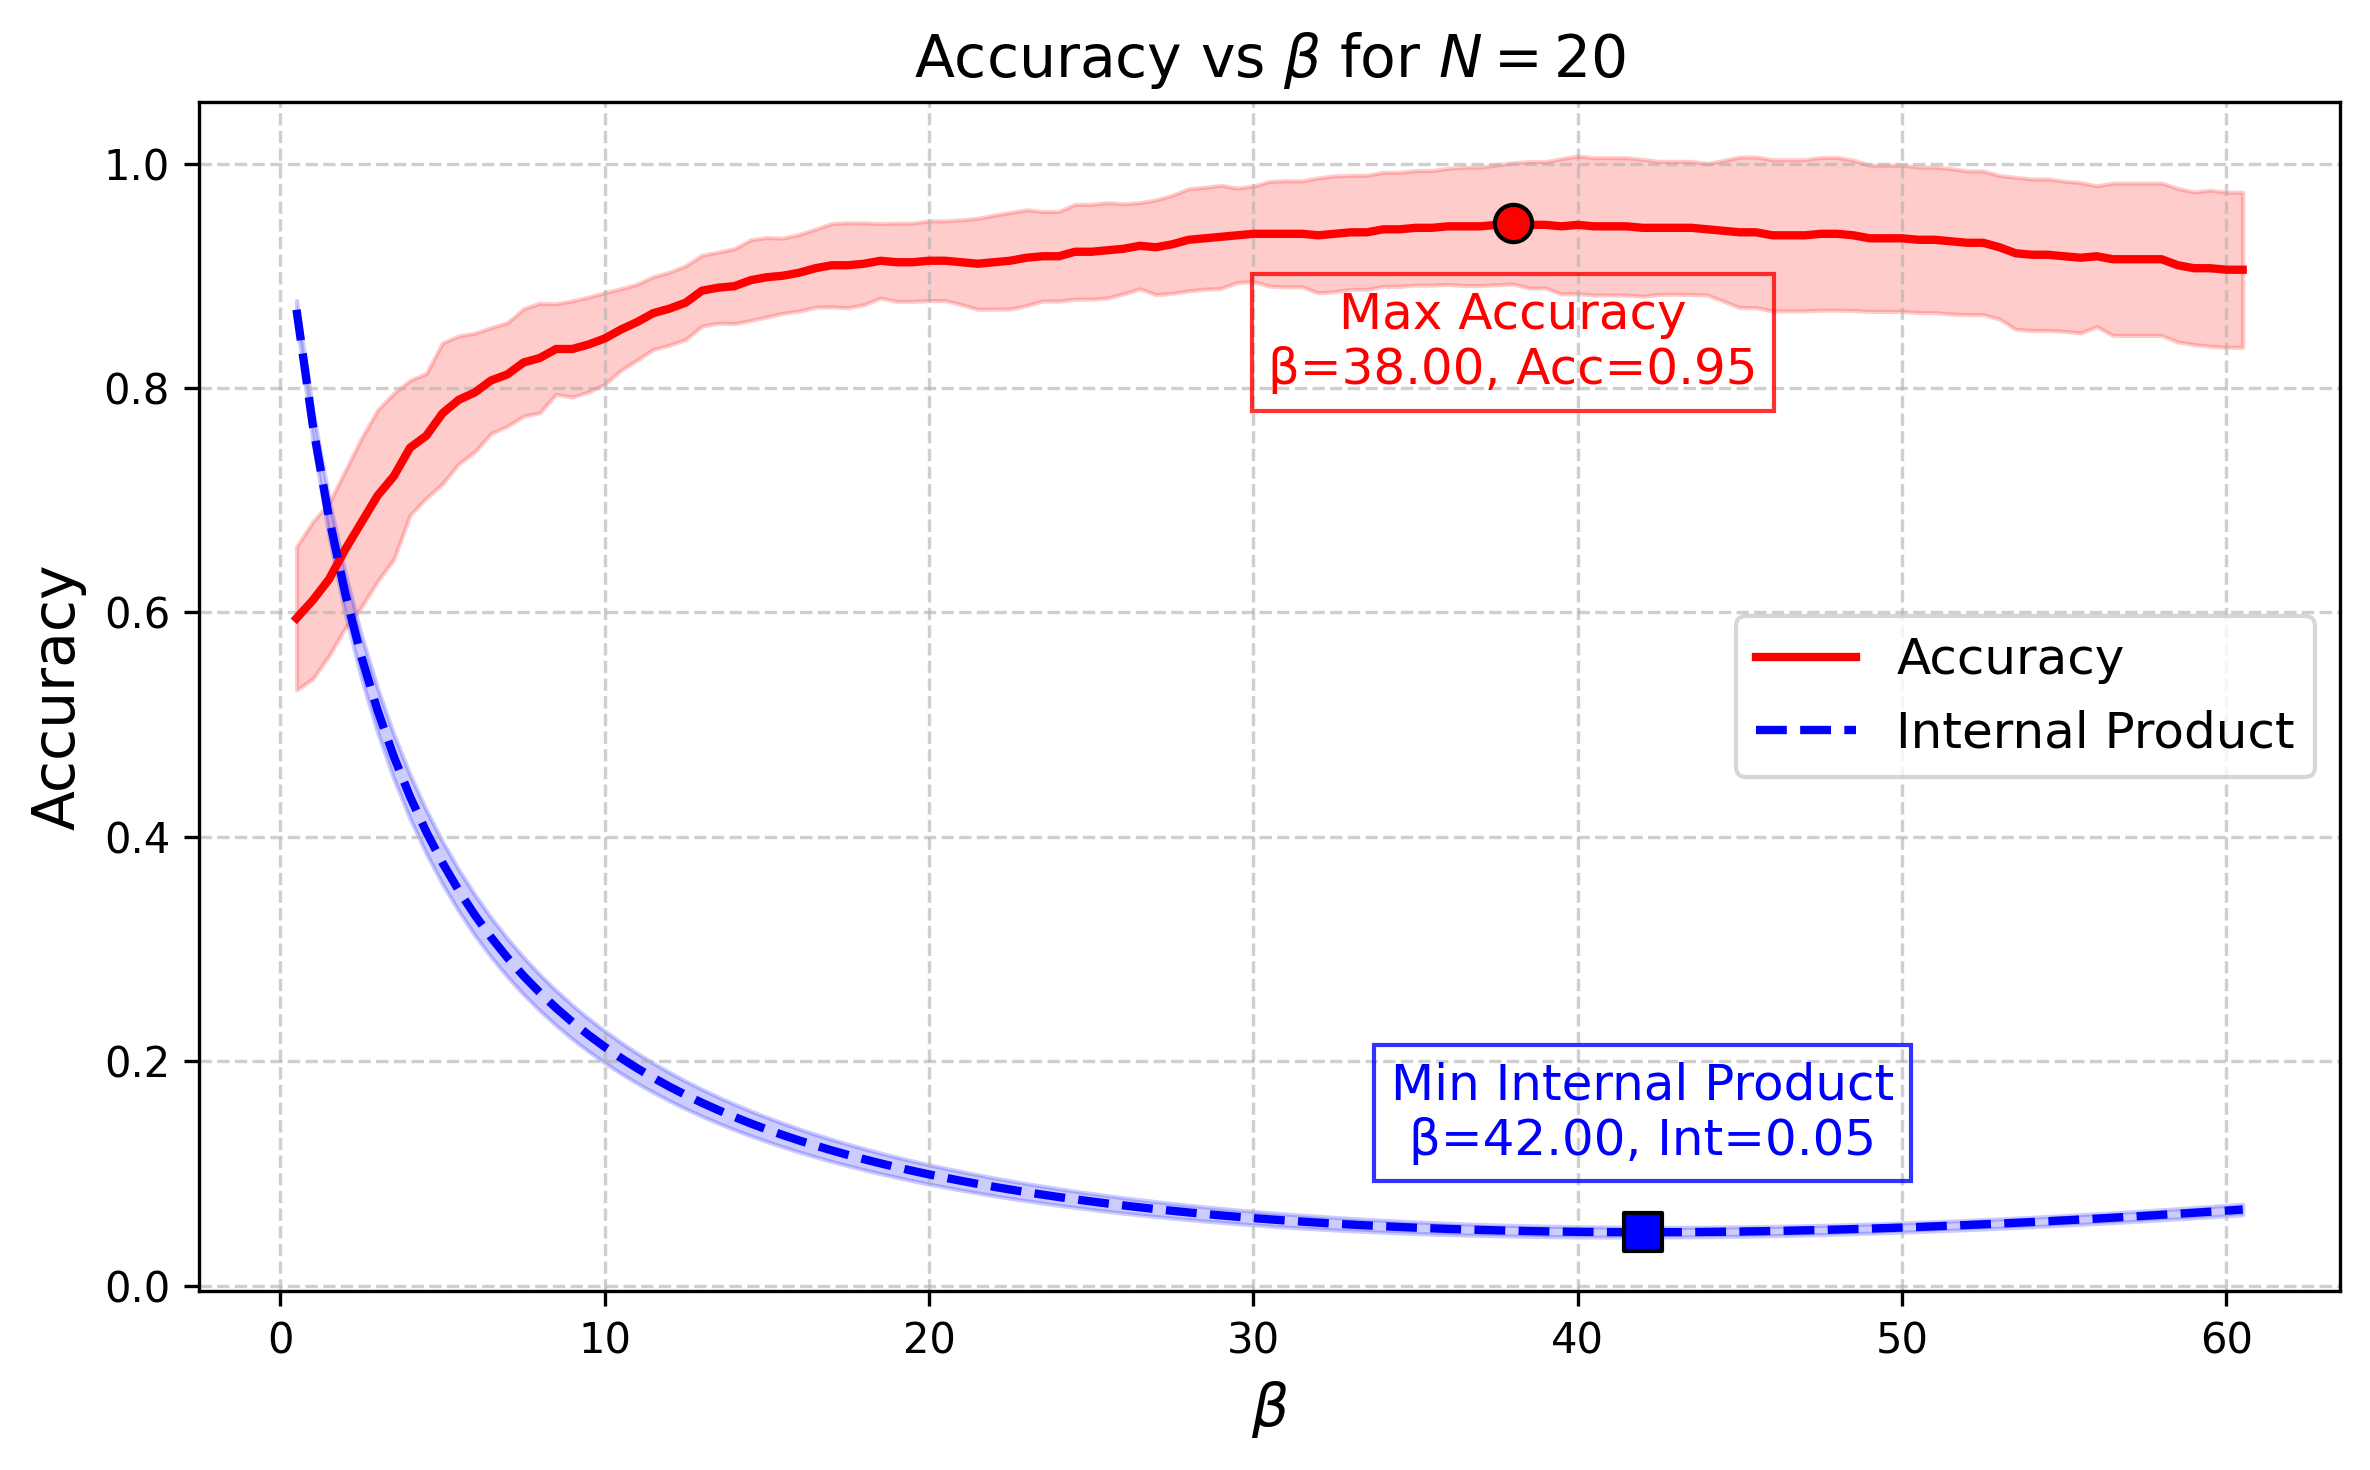

In [108]:
# Plotting Accuracy vs Beta for a fixed N
for fixed_N_index in range(len(N_qfm_arr)):
    print(f'For N = {N_qfm_arr[fixed_N_index]}')

    plt.figure(figsize=(8, 5), dpi=300)  # High-quality figure for papers

    # Plot accuracy for mixed measurement
    plt.plot(param_qfm_arr, acc_mean[fixed_N_index, :, 1], label='Accuracy',
             color='r', linestyle='-', linewidth=2)
    plt.fill_between(param_qfm_arr, acc_mean[fixed_N_index, :, 1] - acc_std[fixed_N_index, :, 1],
                     acc_mean[fixed_N_index, :, 1] + acc_std[fixed_N_index, :, 1],
                     color='r', alpha=0.2)

    # Plot internal product average
    plt.plot(param_qfm_arr, internal_mean[fixed_N_index, :], label='Internal Product',
             color='b', linestyle='--', linewidth=2)
    plt.fill_between(param_qfm_arr, internal_mean[fixed_N_index, :] - internal_std[fixed_N_index, :],
                     internal_mean[fixed_N_index, :] + internal_std[fixed_N_index, :],
                     color='b', alpha=0.2)

    # Identify and mark critical points
    max_acc_index = np.argmax(acc_mean[fixed_N_index, :, 1])
    min_int_index = np.argmin(internal_mean[fixed_N_index, :])

    max_acc_x = param_qfm_arr[max_acc_index]
    max_acc_y = acc_mean[fixed_N_index, max_acc_index, 1]

    min_int_x = param_qfm_arr[min_int_index]
    min_int_y = internal_mean[fixed_N_index, min_int_index]

    plt.scatter(max_acc_x, max_acc_y, color='red', marker='o', s=80,  edgecolors='black', zorder=3)
    plt.scatter(min_int_x, min_int_y, color='blue', marker='s', s=80,  edgecolors='black', zorder=3)

    # Annotate values on the plot with increased spacing from the curves
    plt.text(max_acc_x, max_acc_y - 0.06,  # Move further down
             f'Max Accuracy\nβ={max_acc_x:.2f}, Acc={max_acc_y:.2f}',
             fontsize=12, ha='center', va='top', color='red',
             bbox=dict(facecolor='none', alpha=0.8, edgecolor='red'))

    plt.text(min_int_x, min_int_y + 0.06,  # Move further up
             f'Min Internal Product\nβ={min_int_x:.2f}, Int={min_int_y:.2f}',
             fontsize=12, ha='center', va='bottom', color='blue',
             bbox=dict(facecolor='none', alpha=0.8, edgecolor='blue'))

    # Display max accuracy and min internal product in console
    print(f'Max Accuracy: β = {max_acc_x:.2f}, Accuracy = {max_acc_y:.2f}')
    print(f'Min Internal Product: β = {min_int_x:.2f}, Internal Product = {min_int_y:.2f}')

    # Titles and labels with LaTeX formatting
    plt.title(rf'Accuracy vs $\beta$ for $N = {N_qfm_arr[fixed_N_index]}$', fontsize=14)
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    # Customize legend
    plt.legend(fontsize=12, loc='best', frameon=True)

    # Grid formatting
    plt.grid(True, linestyle="--", alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save figure as high-resolution PNG and vector format
    #plt.savefig(f'accuracy_vs_beta_N{N_qfm_arr[fixed_N_index]}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'accuracy_vs_beta_N{N_qfm_arr[fixed_N_index]}.pdf', dpi=300, bbox_inches='tight')  # Vector format

    plt.show()

In [58]:
#print("\033[34m" + str(acc_mean) + "\033[0m")  # Blue for acc_mean
#print("\033[32m" + str(acc_std) + "\033[0m")  # Green for acc_std
#print("\033[33m" + str(acc_all) + "\033[0m")  # Yellow for acc_all

In [59]:
min_IP_all = np.min(internal_mean)
index_min_IP_all = np.unravel_index(np.argmin(internal_mean), internal_mean.shape)
print('Internal product minimum')
print(N_qfm_arr[index_min_IP_all[0]])
print(param_qfm_arr[index_min_IP_all[1]])
print(min_IP_all)

max_MIXED_all = np.max(acc_mean[:,:,1])
index_max_MIXED_all = np.unravel_index(np.argmax(acc_mean[:,:,1]), acc_mean[:,:,1].shape)
print('Mixed accuracy maximum')
print(N_qfm_arr[index_max_MIXED_all[0]])
print(param_qfm_arr[index_max_MIXED_all[1]])
print(max_MIXED_all)


Internal product minimum
22
47
0.03986649554538747
Mixed accuracy maximum
22
45
0.9620000000000001


In [60]:
for fixed_N_index in range(len(N_qfm_arr)):
  print(f'For N = {N_qfm_arr[fixed_N_index]}')
  min_ip = global_minimum(internal_mean[fixed_N_index, :], np.mean(internal_std[fixed_N_index, :]))
  min_fid = global_minimum(fidelity_mean[fixed_N_index, :], np.mean(fidelity_std[fixed_N_index, :]))
  max_pure = global_maximum(acc_mean[fixed_N_index, :, 0], np.mean(acc_std[fixed_N_index, :, 0]))
  max_mix = global_maximum(acc_mean[fixed_N_index, :, 1], np.mean(acc_std[fixed_N_index, :, 1]))
  max_diag = global_maximum(acc_mean[fixed_N_index, :, 2], np.mean(acc_std[fixed_N_index, :, 2]))


  print(f'Minimum internal mean reached at {param_qfm_arr[min_ip[1]]} with the value of {min_ip[0]}')
  #print(f'Minimum fidelity mean reached at {param_qfm_arr[min_fid[1]]} with the value of {min_fid[0]}')

  print(f'Maximum MIXED accuracy reached at {param_qfm_arr[max_mix[1]]} with the value of {max_mix[0]}')
  #print(f'Maximum pure accuracy reached at {param_qfm_arr[max_pure[1]]} with the value of {max_pure[0]}')
  #print(f'Maximum diagonal accuracy reached at {param_qfm_arr[max_diag[1]]} with the value of {max_diag[0]}')



For N = 18
Minimum internal mean reached at 37 with the value of 0.055404504559936084
Maximum MIXED accuracy reached at 39 with the value of 0.95
For N = 19
Minimum internal mean reached at 39 with the value of 0.05068938358892837
Maximum MIXED accuracy reached at 35 with the value of 0.952
For N = 20
Minimum internal mean reached at 43 with the value of 0.046612048432657226
Maximum MIXED accuracy reached at 43 with the value of 0.9579999999999999
For N = 21
Minimum internal mean reached at 45 with the value of 0.04300709831659886
Maximum MIXED accuracy reached at 45 with the value of 0.9599999999999997
For N = 22
Minimum internal mean reached at 47 with the value of 0.03986649554538747
Maximum MIXED accuracy reached at 45 with the value of 0.9620000000000001


For Coherent, Spirals, dim = 32, numpoints=200, 7 random

*   Minimum internal mean reached in 64.9625 with value 0.013364475339075274
*   Minimum fidelity mean reached in 48.6 with value 0.09765225252448362
*   Maximum MIXED accuracy reached in 44.1375 with value 0.9657142857142856
*   Maximum pure accuracy reached in 66.45 with value 0.85
*   Maximum diagonal accuracy reached in 41.1625 with value 0.9228571428571427

For Coherent, Moons, ...

*  Minimum internal mean reached at 47.112500000000004 with the value of 0.0008042185802515273
*  Minimum fidelity mean reached at 47.112500000000004 with the value of 0.004002503688026683
*  Maximum MIXED accuracy reached at 23.3125 with the value of 0.9942857142857143
*  Maximum pure accuracy reached at 35.2125 with the value of 0.9942857142857143
*  Maximum diagonal accuracy reached at 39.675000000000004 with the value of 0.9771428571428572



## Smoothed plot, just for checking the smoothing

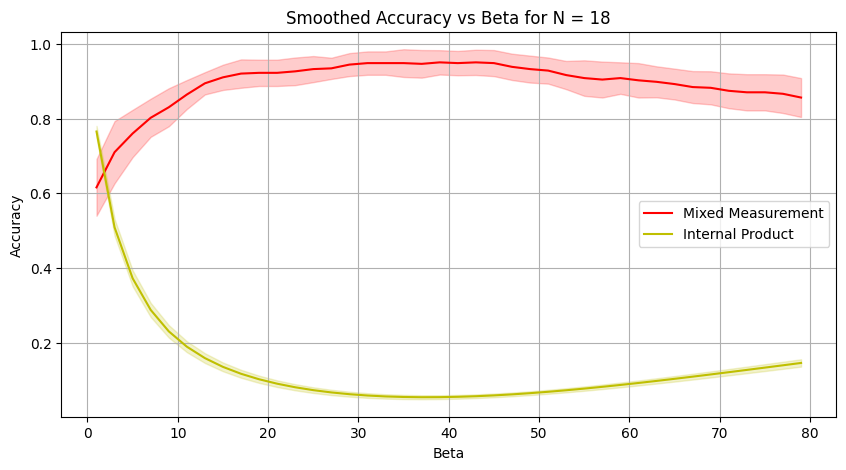

In [61]:
# Plotting Accuracy vs Beta for a fixed N
fixed_N_index = 0

plt.figure(figsize=(10, 5))

sigma_pure  = np.mean(acc_std[fixed_N_index, :, 0])
sigma_mixed = np.mean(acc_std[fixed_N_index, :, 1])
sigma_diag  = np.mean(acc_std[fixed_N_index, :, 2])
pure_smooth = gaussian_filter(acc_mean[fixed_N_index, :, 0], sigma=sigma_pure)
mixed_smooth = gaussian_filter(acc_mean[fixed_N_index, :, 1], sigma=sigma_mixed)
diag_smooth = gaussian_filter(acc_mean[fixed_N_index, :, 2], sigma=sigma_diag)

sigma_internal = np.mean(internal_std[fixed_N_index, :])
internal_smooth = gaussian_filter(internal_mean[fixed_N_index, :], sigma=sigma_internal)

sigma_fidelity = np.mean(fidelity_std[fixed_N_index, :])
fidelity_smooth = gaussian_filter(fidelity_mean[fixed_N_index, :], sigma=sigma_fidelity)

# Plot accuracy for pure measurement
#plt.plot(param_qfm_arr, pure_smooth, label='Pure Measurement', color='b')
#plt.fill_between(param_qfm_arr, acc_mean[fixed_N_index, :, 0] - acc_std[fixed_N_index, :, 0], acc_mean[fixed_N_index, :, 0] + acc_std[fixed_N_index, :, 0], color='b', alpha=0.2)
# Plot accuracy for mixed measurement
plt.plot(param_qfm_arr, mixed_smooth, label='Mixed Measurement',color='r')
plt.fill_between(param_qfm_arr, acc_mean[fixed_N_index, :, 1] - acc_std[fixed_N_index, :, 1], acc_mean[fixed_N_index, :, 1] + acc_std[fixed_N_index, :, 1], color='r', alpha=0.2)
# Plot accuracy for diagonal of mixed measurement
#plt.plot(param_qfm_arr, diag_smooth, label='Clasical Measurement', color='g')
#plt.fill_between(param_qfm_arr, acc_mean[fixed_N_index, :, 2] - acc_std[fixed_N_index, :, 2], acc_mean[fixed_N_index, :, 2] + acc_std[fixed_N_index, :, 2], color='g', alpha=0.2)
# Plot internal product average
plt.plot(param_qfm_arr, internal_smooth, label='Internal Product', color='y')
plt.fill_between(param_qfm_arr, internal_mean[fixed_N_index, :] - internal_std[fixed_N_index, :], internal_mean[fixed_N_index, :] + internal_std[fixed_N_index, :], color='y', alpha=0.2)
# Plot fidelity average
#plt.plot(param_qfm_arr, fidelity_smooth, label='Fidelity', color='m')
#plt.fill_between(param_qfm_arr, fidelity_mean[fixed_N_index, :] - fidelity_std[fixed_N_index, :], fidelity_mean[fixed_N_index, :] + fidelity_std[fixed_N_index, :], color='m', alpha=0.2)


plt.title(f'Smoothed Accuracy vs Beta for N = {N_qfm_arr[fixed_N_index]}')
plt.xlabel('Beta')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Trash

In [62]:
'''''''''''''''
### COHERENT

num_points = 1000
N_qfm = 30 #Dimensions of QFM
param_qfm = 70 #Parameter
N_grid = 50 #Number of points in grid per axis
quantum_feature_map = coherent
dataset = 'Spiral'
random_max = 10

acc_mean = np.zeros(3)
acc_std = np.zeros(3)

acc_all_seeds = np.zeros((random_max, 3))
for random_seed in range(random_max):
    accuracy = np.zeros(3) #The for pure and mixed and diagonal

    train_arr, train_lb, test_arr, test_lb = generate_spirals(num_points, random_seed)

    grid_QFM, grid_xy = make_grid(quantum_feature_map, N_qfm, param_qfm, N_grid)

    train_QFM_x0, train_QFM_x1, test_QFM_x = make_QFM(quantum_feature_map, N_qfm, param_qfm, train_arr, train_lb, test_arr)

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[0] = measurement_pure( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM)

    plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[0], dataset, quantum_feature_map, 'pure')

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[1], mdensity_x0, mdensity_x1 = measurement_mixed( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM)

    plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[1], dataset, quantum_feature_map, 'mixed')

    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[2] = measurement_diagonal( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM, density_x0 = mdensity_x0, density_x1 = mdensity_x1)

    plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[2], dataset, quantum_feature_map, 'classical')

    acc_all_seeds[random_seed] = accuracy


acc_mean = np.mean(acc_all_seeds, axis=0)
acc_std = np.std(acc_all_seeds, axis=0)
print(acc_mean)
print(acc_std)

'''''''''''''''

"\n### COHERENT\n\nnum_points = 1000\nN_qfm = 30 #Dimensions of QFM\nparam_qfm = 70 #Parameter\nN_grid = 50 #Number of points in grid per axis\nquantum_feature_map = coherent\ndataset = 'Spiral'\nrandom_max = 10\n\nacc_mean = np.zeros(3)\nacc_std = np.zeros(3)\n\nacc_all_seeds = np.zeros((random_max, 3))\nfor random_seed in range(random_max):\n    accuracy = np.zeros(3) #The for pure and mixed and diagonal\n\n    train_arr, train_lb, test_arr, test_lb = generate_spirals(num_points, random_seed)\n\n    grid_QFM, grid_xy = make_grid(quantum_feature_map, N_qfm, param_qfm, N_grid)\n\n    train_QFM_x0, train_QFM_x1, test_QFM_x = make_QFM(quantum_feature_map, N_qfm, param_qfm, train_arr, train_lb, test_arr)\n\n    P_x0, P_x1, P_x0_grid, P_x1_grid, accuracy[0] = measurement_pure( train_QFM_x0, train_QFM_x1, test_QFM_x, test_lb, grid_QFM)\n\n    plot_clasification(grid_xy, test_arr, test_lb, P_x0_grid, P_x1_grid, accuracy[0], dataset, quantum_feature_map, 'pure')\n\n    P_x0, P_x1, P_x0_grid, 